In [ ]:
!pip install efficientnet

In [16]:
### standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from PIL import Image as PImage
### deep learning imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.models import Model, load_model

In [3]:
BUCKET_NAME = 'wagon-data-745-project-yoda'
BUCKET_DATA_PATH = 'raw_data'

In [4]:
def get_dataframes_from_gcp(optimize=False, **kwargs):
    """method to get the training data from google cloud bucket"""
    base_path = f"gs://{BUCKET_NAME}/{BUCKET_DATA_PATH}"
    index = pd.read_csv(f'{base_path}/index.csv')
    metadata = pd.read_csv(f'{base_path}/metadata.csv')
    df = pd.merge(index, metadata, on='class_id')

    # put all but 2 images of each class in training set, rest in validation set
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])
    for i in range(1,len(df['class_id'].value_counts())+1):
        df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])
        df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

    return df_train, df_valid

In [6]:
index = pd.read_csv('../raw_data/index.csv')
index.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [7]:
metadata = pd.read_csv('../raw_data/metadata.csv')
metadata.head()

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


In [8]:
df = pd.merge(index, metadata, on='class_id')
df.head()

,path,class_id,lego_ids,lego_names,minifigure_name
0,marvel/0001/001.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,marvel/0001/002.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,marvel/0001/003.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
3,marvel/0001/004.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
4,marvel/0001/005.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


In [9]:
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])

for i in range(1,len(df['class_id'].value_counts())+1):
    df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])    
    df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

In [11]:
root_dir = "../raw_data/"

In [12]:
def loadImages(root_dir, df):
    

    loadedImages = []
    for image in df['path']:
        img = PImage.open(root_dir + image)
        loadedImages.append(img)
    

    return loadedImages


# your images in an array
imgs = loadImages(root_dir, df)


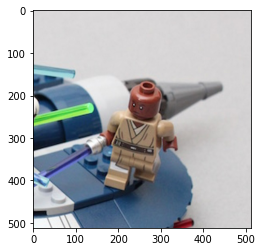

In [13]:
import matplotlib.pyplot as plt
plt.imshow(imgs[80])

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range = 30,
                                       width_shift_range = 0.3,
                                       height_shift_range = 0.3,
                                       brightness_range=[0.2,1.0],
                                       shear_range = 0.3,
                                       zoom_range = 0.4,
                                       fill_mode='nearest',
                                       vertical_flip=True,
                                       horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=root_dir,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=(512, 512),
        batch_size=16)
valid_generator = test_datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory=root_dir,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=(512, 512),
        batch_size=16,
        shuffle=False)

Found 287 validated image filenames belonging to 36 classes.
Found 74 validated image filenames belonging to 36 classes.


In [17]:
early_stop = callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)

In [30]:
model = EfficientNetB6(weights='imagenet',
                      input_shape=(512,512,3),
                      include_top=False,
                      pooling='avg')

x = Dropout(0.3)(model.output)    # adding Droupout layer to the model.
prediction_efn = Dense(36, activation='softmax')(x)
model = Model(model.input, prediction_efn)

model.compile(optimizers.Adam(lr=0.0001),
loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 512, 512, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 512, 512, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block3f_expand_activation (Act  (None, 64, 64, 432)  0          ['block3f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3f_dwconv (DepthwiseConv2  (None, 64, 64, 432)  10800      ['block3f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3f_bn (BatchNormalization  (None, 64, 64, 432)  1728       ['block3f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3f_a

 block5d_project_bn (BatchNorma  (None, 32, 32, 200)  800        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (Dropout)         (None, 32, 32, 200)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 32, 32, 200)  0           ['block5d_drop[0][0]',           
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 32, 32, 1200  240000      ['block5d_add[0][0]']            
                                )                                                                 
          

 block7c_expand_activation (Act  (None, 16, 16, 3456  0          ['block7c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7c_dwconv (DepthwiseConv2  (None, 16, 16, 3456  31104      ['block7c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block7c_bn (BatchNormalization  (None, 16, 16, 3456  13824      ['block7c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block7c_activation (Activation  (None, 16, 16, 3456  0          ['block7c_bn[0][0]']             
 )        

In [ ]:
model.fit(x=train_generator, 
          validation_data=valid_generator, 
          epochs=20, 
          callbacks=[early_stop])